In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

import sklearn
print("start")

f=open(r'.\交通银行601328.csv')
d=pd.read_csv(f)

d= d.sort_index(ascending=False)  #按照index降序排列
#print(d)
#print("///////////////////////////////")
d=d.reset_index(drop=True)
#print(d)
d_row=d.shape[0]  #2419行
#print(d[0:1])
#print("***************")
#print(d.iloc[0])
#t=d.iloc[0]
#t=t[['open','close']]
#k=np.array(t)
#print("k:",k)

d=d.iloc[:,:].values

before=5
after=1

train_x=[]
train_y=[]
input_list=[]
label_list=[]
label_date_list=[] #带有date的label
dates_list=[]

size=d_row-1-(before+after-1)+1
for i in range(d_row-1-(before+after-1)+1):
    x1=d[i:i+before,1:5]  #第0列是日期，取1到4列，分别是open，close，high，low
    x1=x1.tolist()
    input_list.append(x1)
    
    y1=d[i+before:i+before+after,2:3]  #出错点，只取第2号列，close
    y1=y1.tolist() #出错点,y1此时的形状是(after,1),我们想要的是(1,after)，要进行转换。其实也可不用，之后有reshape(-1,n_classes)语句会转换
    y1=np.array(y1).reshape(1,after)
    label_list.append(y1)
    
    dates_list.append(d[i+before:i+before+after,0:1])
    
   # y2=d[i+before:i+before+after,0:5]
   # y2=y2.tolist()
   # y2=np.array(y2).reshape(1,after)
   # label_date_list.append(y2)

#print(len(input_list))
input_list=np.array(input_list)
#print(input_list.shape)  #(size,before,4) ,4是指提出了x的4个属性
label_list=np.array(label_list)
dates=np.array(dates_list)

#    ------------划分训练集，测试集-------------
train_proportion=0.7
end=int(size*train_proportion)
#print("end:",end)

train_x=input_list[0:end,:,:]
#print(train_x.shape)  #(1447,5,4)
train_y=label_list[0:end,:,:]

test_x=input_list[end:size,:,:]
test_y=label_list[end:size,:,:]


#print("dates.shape:",dates.shape)
test_dates=dates[end:size,:,:]

batch_index=[]  #对于输入，按照批次喂入网络
batch_size=60
for i in range(train_x.shape[0]):
    if(i%batch_size==0 or i==train_x.shape[0]-1):
        batch_index.append(i)

print("len(batch_size):",len(batch_index))
        
input_size=4  #input_size=x的属性数量
time_steps=before  #
num_units=128 #num_units
n_classes=after   # 

x=tf.placeholder(tf.float32,[None,time_steps,input_size])
y=tf.placeholder(tf.float32,[None,n_classes])   #y是label，正确答案

w=tf.Variable(tf.truncated_normal([num_units,n_classes],stddev=0.1))
b=tf.Variable(tf.constant(0.1,shape=[n_classes]))

def lstm(X,w,b):
    #inputs=tf.reshape(X,[-1,time_steps,input_size])
    inputs=X
    lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units)
    outputs,final_state=tf.nn.dynamic_rnn(lstm_cell,inputs,dtype=tf.float32) #tf.nn.dynamic_rnn最好参见tensorflow官网解释
    #final_state[0]=cell state
    #final_state[1]=hidden state
    #results=tf.nn.softmax(tf.matmul(final_state[1],w)+b)
    results=(tf.matmul(final_state[1],w)+b)
    return results
    
prediction=lstm(x,w,b)
#cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
loss=tf.reduce_mean(tf.square(y-prediction))
train_step=tf.train.AdamOptimizer(1e-3).minimize(loss)   #hinton建议设置为1e-3，代表初始学习率

#correct_prediction=tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
#accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))      

with tf.Session() as sess:
    init_op=tf.global_variables_initializer()
    sess.run(init_op)
    for epoch in range(100):
        for step in range(len(batch_index)-1):
            y_trans=(train_y[batch_index[step]:batch_index[step+1]]).reshape(-1,n_classes)  #转换之前y的形状是,(-1,1,3)
            sess.run(train_step,feed_dict={x:train_x[batch_index[step]:batch_index[step+1]],y:y_trans})
            
        total_loss=sess.run(loss,feed_dict={x:test_x[0:60],y:test_y[0:60].reshape(-1,n_classes)})
        y_predict_lstm=sess.run(prediction,feed_dict={x:test_x[0:60],y:test_y[0:60].reshape(-1,n_classes)})
        print(str(epoch)+" times,loss:"+str(total_loss))
        
    print("y_predict:",y_predict_lstm)

print("over")

start
len(batch_size): 30
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
0 times,loss:9.318325
1 times,loss:5.796542
2 times,loss:6.669049
3 times,loss:7.475038
4 times,loss:8.346958
5 times,loss:8.685006
6 times,loss:6.319751
7 times,loss:4.988372
8 times,loss:4.264439
9 times,loss:3.485133
10 times,loss:2.935711
11 times,loss:1.735988
12 times,loss:1.3081709
13 times,loss:0.95035666
14 times,loss:0.7479647
15 times,loss:0.6041165
16 times,loss:0.4865254
17 times,loss:0.39567846
18 times,loss:0.32732582
19 times,loss:0.2704272
20 times,loss:0.22216277
21 times,loss:0.17575477
22 times,loss:0.13301386
23 times,loss:0.101625584
24 times,loss:0.086309165
25 times,loss:0.08382622
26 times,loss:0.08639259
27 times,loss:0.08775143
28 times,loss:0.087455995
29 times,loss:0.08425369
30 times,loss:0.07941387
31 

In [2]:
y_real=test_y[0:60].reshape(-1,n_classes)
print("y_real:",y_real)

y_real: [[ 9.64]
 [ 9.96]
 [10.49]
 [ 9.44]
 [ 9.43]
 [ 9.95]
 [10.01]
 [ 9.98]
 [ 9.83]
 [ 9.5 ]
 [ 9.29]
 [ 9.19]
 [ 9.06]
 [ 8.67]
 [ 8.93]
 [ 8.76]
 [ 8.73]
 [ 8.58]
 [ 8.77]
 [ 8.95]
 [ 8.9 ]
 [ 8.89]
 [ 8.89]
 [ 8.84]
 [ 8.87]
 [ 8.76]
 [ 8.9 ]
 [ 8.84]
 [ 8.84]
 [ 8.55]
 [ 8.51]
 [ 8.26]
 [ 8.48]
 [ 8.9 ]
 [ 8.84]
 [ 8.89]
 [ 9.25]
 [ 9.15]
 [ 9.22]
 [ 9.31]
 [ 9.51]
 [ 9.37]
 [ 9.43]
 [ 9.5 ]
 [ 9.38]
 [ 9.13]
 [ 9.16]
 [ 9.19]
 [ 9.44]
 [ 9.29]
 [ 9.35]
 [ 9.28]
 [ 9.31]
 [ 9.53]
 [ 9.72]
 [ 9.64]
 [ 9.86]
 [10.08]
 [ 9.95]
 [10.18]]


In [6]:
dates=test_dates[0:60].reshape(-1)
print(dates)
print(dates.shape)



['2015-01-14' '2015-01-15' '2015-01-16' '2015-01-19' '2015-01-20'
 '2015-01-21' '2015-01-22' '2015-01-23' '2015-01-26' '2015-01-27'
 '2015-01-28' '2015-01-29' '2015-01-30' '2015-02-02' '2015-02-03'
 '2015-02-04' '2015-02-05' '2015-02-06' '2015-02-09' '2015-02-10'
 '2015-02-11' '2015-02-12' '2015-02-13' '2015-02-16' '2015-02-17'
 '2015-02-25' '2015-02-26' '2015-02-27' '2015-03-02' '2015-03-03'
 '2015-03-04' '2015-03-05' '2015-03-06' '2015-03-09' '2015-03-10'
 '2015-03-11' '2015-03-12' '2015-03-13' '2015-03-16' '2015-03-17'
 '2015-03-18' '2015-03-19' '2015-03-20' '2015-03-23' '2015-03-24'
 '2015-03-25' '2015-03-26' '2015-03-27' '2015-03-30' '2015-03-31'
 '2015-04-01' '2015-04-02' '2015-04-03' '2015-04-07' '2015-04-08'
 '2015-04-09' '2015-04-10' '2015-04-13' '2015-04-14' '2015-04-15']
(60,)


In [1]:
# --------------------------------------DNN神经网络模型（对比试验）-----------------------------
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

import sklearn
print("start")

f=open(r'.\交通银行601328.csv')
d=pd.read_csv(f)

d= d.sort_index(ascending=False)  #按照index降序排列
#print(d)
#print("///////////////////////////////")
d=d.reset_index(drop=True)
#print(d)
d_row=d.shape[0]  #2419行
#print(d[0:1])
#print("***************")
#print(d.iloc[0])
#t=d.iloc[0]
#t=t[['open','close']]
#k=np.array(t)
#print("k:",k)

d=d.iloc[:,:].values

before=5
after=1

train_x=[]
train_y=[]
input_list=[]
label_list=[]
label_date_list=[] #带有date的label
dates_list=[]

size=d_row-1-(before+after-1)+1
for i in range(d_row-1-(before+after-1)+1):
    x1=d[i:i+before,1:5]  #第0列是日期，取1到4列，分别是open，close，high，low
    x1=x1.tolist()
    input_list.append(x1)
    
    y1=d[i+before:i+before+after,2:3]  #出错点，只取第2号列，close
    y1=y1.tolist() #出错点,y1此时的形状是(after,1),我们想要的是(1,after)，要进行转换。其实也可不用，之后有reshape(-1,n_classes)语句会转换
    y1=np.array(y1).reshape(1,after)
    label_list.append(y1)
    
    dates_list.append(d[i+before:i+before+after,0:1])
    
   # y2=d[i+before:i+before+after,0:5]
   # y2=y2.tolist()
   # y2=np.array(y2).reshape(1,after)
   # label_date_list.append(y2)

#print(len(input_list))
input_list=np.array(input_list)
#print(input_list.shape)  #(size,before,4) ,4是指提出了x的4个属性
label_list=np.array(label_list)
dates=np.array(dates_list)

#    ------------划分训练集，测试集-------------
train_proportion=0.7
end=int(size*train_proportion)
#print("end:",end)

train_x=input_list[0:end,:,:]
#print(train_x.shape)  #(1447,5,4)
train_y=label_list[0:end,:,:]

test_x=input_list[end:size,:,:]
test_y=label_list[end:size,:,:]


#print("dates.shape:",dates.shape)
test_dates=dates[end:size,:,:]

batch_index=[]  #对于输入，按照批次喂入网络
batch_size=60
for i in range(train_x.shape[0]):
    if(i%batch_size==0 or i==train_x.shape[0]-1):
        batch_index.append(i)

        
before=5
after=1
day_classes=4   #利用每一天的 open,close,high,low, 4个属性值
#size=2416 #输入2416组数据
input_node=before*day_classes
output_node=1
layer=10 #一层隐藏层，节点数设置为10个
n_classes=1

x=tf.placeholder(tf.float32,shape=[None,input_node])
y_=tf.placeholder(tf.float32,shape=[None,output_node])

w1=tf.Variable(tf.random_normal([input_node,layer],stddev=1,seed=1))
b1=tf.Variable(tf.zeros([layer]))
#a=(tf.matmul(x,w1)+b1)  
a=tf.nn.sigmoid(tf.matmul(x,w1)+b1)  #sigmoid效果并不好
#tf.truncated_normal(shape=[10,10], mean=0, stddev=0.1)

w2=tf.Variable(tf.random_normal([layer,output_node],stddev=1,seed=1))
b2=tf.Variable(tf.zeros([output_node]))
y=tf.matmul(a,w2)+b2

print("a:",a)

global_step=tf.Variable(0,trainable=False)
#learning_rate=tf.train.exponential_decay(0.01,global_step,1,0.9999,staircase=True)  #初始学习率必须自己调节到最合适的！

loss=tf.reduce_mean(tf.square(y-y_))
train_step=tf.train.AdamOptimizer(1e-3).minimize(loss,global_step=global_step)   #hinton建议设置为1e-3，代表初始学习率
#train_step=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)

with tf.Session() as sess:
    init_op=tf.global_variables_initializer()
    sess.run(init_op)
    for epoch in range(4000):
        for step in range(len(batch_index)-1):
            y_trans=(train_y[batch_index[step]:batch_index[step+1]]).reshape(-1,n_classes)  #转换之前y的形状是,(-1,1,n_classes)
            sess.run(train_step,feed_dict={x:train_x[batch_index[step]:batch_index[step+1]].reshape(-1,input_node),y_:y_trans})
            
        total_loss=sess.run(loss,feed_dict={x:test_x[0:60].reshape(-1,input_node),y_:test_y[0:60].reshape(-1,n_classes)})
        y_predict_dnn=sess.run(y,feed_dict={x:test_x[0:60].reshape(-1,input_node),y_:test_y[0:60].reshape(-1,n_classes)})
        print(str(epoch)+" times,loss:"+str(total_loss))
        
    print("y_predict_dnn:",y_predict_dnn)

print("over")
        

   # w1_a=w1.eval()  #在启动会话之后，eval可以将tensor转换成array类型
   # print("w1_a.shape",w1_a.shape)
   # print(type(w1_a))



start
Instructions for updating:
Colocations handled automatically by placer.
a: Tensor("Sigmoid:0", shape=(?, 10), dtype=float32)
0 times,loss:91.42354
1 times,loss:81.82326
2 times,loss:80.61209
3 times,loss:54.427162
4 times,loss:51.769585
5 times,loss:50.446247
6 times,loss:49.23122
7 times,loss:48.07861
8 times,loss:46.970455
9 times,loss:45.89787
10 times,loss:44.855762
11 times,loss:43.840942
12 times,loss:42.851265
13 times,loss:41.88518
14 times,loss:40.941525
15 times,loss:40.019363
16 times,loss:39.11797
17 times,loss:38.23669
18 times,loss:37.374985
19 times,loss:36.532345
20 times,loss:35.70834
21 times,loss:34.902554
22 times,loss:34.114616
23 times,loss:33.34416
24 times,loss:32.59084
25 times,loss:31.854336
26 times,loss:31.134327
27 times,loss:30.430515
28 times,loss:29.742615
29 times,loss:29.070326
30 times,loss:28.413366
31 times,loss:27.77146
32 times,loss:27.144356
33 times,loss:26.531782
34 times,loss:25.933483
35 times,loss:25.349194
36 times,loss:24.778675
37 t

330 times,loss:2.198234
331 times,loss:2.186171
332 times,loss:2.174188
333 times,loss:2.1623344
334 times,loss:2.1505666
335 times,loss:2.1388924
336 times,loss:2.127333
337 times,loss:2.1158671
338 times,loss:2.1045115
339 times,loss:2.0932503
340 times,loss:2.082098
341 times,loss:2.0710433
342 times,loss:2.060109
343 times,loss:2.0492609
344 times,loss:2.0385277
345 times,loss:2.0279021
346 times,loss:2.0173848
347 times,loss:2.0069594
348 times,loss:1.9966413
349 times,loss:1.986432
350 times,loss:1.9763254
351 times,loss:1.9663297
352 times,loss:1.9564357
353 times,loss:1.9466377
354 times,loss:1.9369605
355 times,loss:1.9273895
356 times,loss:1.9178962
357 times,loss:1.9085238
358 times,loss:1.8992449
359 times,loss:1.8900748
360 times,loss:1.8810095
361 times,loss:1.8720449
362 times,loss:1.8631834
363 times,loss:1.8544143
364 times,loss:1.8457459
365 times,loss:1.8371785
366 times,loss:1.8287147
367 times,loss:1.8203361
368 times,loss:1.8120693
369 times,loss:1.8038851
370 tim

664 times,loss:0.6689427
665 times,loss:0.6655072
666 times,loss:0.662054
667 times,loss:0.65855694
668 times,loss:0.6550363
669 times,loss:0.6514782
670 times,loss:0.647894
671 times,loss:0.6442613
672 times,loss:0.6405963
673 times,loss:0.63689303
674 times,loss:0.63314384
675 times,loss:0.62934834
676 times,loss:0.62549216
677 times,loss:0.62159616
678 times,loss:0.6176364
679 times,loss:0.61361545
680 times,loss:0.6095365
681 times,loss:0.6053916
682 times,loss:0.60117215
683 times,loss:0.59687936
684 times,loss:0.59250295
685 times,loss:0.5880396
686 times,loss:0.58348525
687 times,loss:0.57884914
688 times,loss:0.57410353
689 times,loss:0.56924045
690 times,loss:0.56425637
691 times,loss:0.55915195
692 times,loss:0.55391556
693 times,loss:0.54853004
694 times,loss:0.5429849
695 times,loss:0.53727585
696 times,loss:0.5313975
697 times,loss:0.52533156
698 times,loss:0.5190596
699 times,loss:0.5125669
700 times,loss:0.5058384
701 times,loss:0.4988579
702 times,loss:0.4916077
703 tim

995 times,loss:0.24374284
996 times,loss:0.24359421
997 times,loss:0.24344516
998 times,loss:0.24329473
999 times,loss:0.24314205
1000 times,loss:0.24298863
1001 times,loss:0.24283399
1002 times,loss:0.2426775
1003 times,loss:0.2425212
1004 times,loss:0.24236241
1005 times,loss:0.24220182
1006 times,loss:0.24204183
1007 times,loss:0.24187972
1008 times,loss:0.24171816
1009 times,loss:0.24155511
1010 times,loss:0.24139138
1011 times,loss:0.24122676
1012 times,loss:0.24106112
1013 times,loss:0.24089569
1014 times,loss:0.24072939
1015 times,loss:0.24056146
1016 times,loss:0.24039428
1017 times,loss:0.24022749
1018 times,loss:0.2400596
1019 times,loss:0.23989223
1020 times,loss:0.23972318
1021 times,loss:0.23955631
1022 times,loss:0.23938747
1023 times,loss:0.23921818
1024 times,loss:0.23905022
1025 times,loss:0.23888248
1026 times,loss:0.23871367
1027 times,loss:0.23854525
1028 times,loss:0.23837675
1029 times,loss:0.23820911
1030 times,loss:0.2380407
1031 times,loss:0.23787266
1032 times

1301 times,loss:0.21579549
1302 times,loss:0.23326796
1303 times,loss:0.21562795
1304 times,loss:0.23328784
1305 times,loss:0.21546273
1306 times,loss:0.23330656
1307 times,loss:0.21529767
1308 times,loss:0.23332329
1309 times,loss:0.21513385
1310 times,loss:0.23333791
1311 times,loss:0.21497098
1312 times,loss:0.2333532
1313 times,loss:0.21480909
1314 times,loss:0.2333657
1315 times,loss:0.21464725
1316 times,loss:0.23337533
1317 times,loss:0.2144869
1318 times,loss:0.23338404
1319 times,loss:0.21432737
1320 times,loss:0.23339225
1321 times,loss:0.21416861
1322 times,loss:0.23339961
1323 times,loss:0.21401009
1324 times,loss:0.23339954
1325 times,loss:0.21385302
1326 times,loss:0.2334042
1327 times,loss:0.21369654
1328 times,loss:0.23340212
1329 times,loss:0.2135408
1330 times,loss:0.233402
1331 times,loss:0.21338691
1332 times,loss:0.23339888
1333 times,loss:0.21323285
1334 times,loss:0.23339479
1335 times,loss:0.21307968
1336 times,loss:0.23338777
1337 times,loss:0.21292731
1338 tim

1614 times,loss:0.2116387
1615 times,loss:0.19750796
1616 times,loss:0.21137477
1617 times,loss:0.19744559
1618 times,loss:0.21111245
1619 times,loss:0.19738461
1620 times,loss:0.21084706
1621 times,loss:0.19732602
1622 times,loss:0.21057984
1623 times,loss:0.1972691
1624 times,loss:0.21031408
1625 times,loss:0.19721293
1626 times,loss:0.21004756
1627 times,loss:0.19715975
1628 times,loss:0.20978107
1629 times,loss:0.19710732
1630 times,loss:0.2095112
1631 times,loss:0.19705926
1632 times,loss:0.20924191
1633 times,loss:0.19701344
1634 times,loss:0.20897005
1635 times,loss:0.19697045
1636 times,loss:0.20869945
1637 times,loss:0.19693014
1638 times,loss:0.20842624
1639 times,loss:0.1968914
1640 times,loss:0.20815058
1641 times,loss:0.1968577
1642 times,loss:0.20787697
1643 times,loss:0.19682589
1644 times,loss:0.20760101
1645 times,loss:0.196797
1646 times,loss:0.20732352
1647 times,loss:0.19677266
1648 times,loss:0.20704736
1649 times,loss:0.19675638
1650 times,loss:0.20676874
1651 tim

1926 times,loss:0.19886619
1927 times,loss:0.19883189
1928 times,loss:0.19879986
1929 times,loss:0.19876696
1930 times,loss:0.1987334
1931 times,loss:0.19870104
1932 times,loss:0.19866899
1933 times,loss:0.19863676
1934 times,loss:0.19860326
1935 times,loss:0.19857267
1936 times,loss:0.1985406
1937 times,loss:0.19850914
1938 times,loss:0.19847721
1939 times,loss:0.19844489
1940 times,loss:0.19841191
1941 times,loss:0.19838066
1942 times,loss:0.19835041
1943 times,loss:0.1983189
1944 times,loss:0.19828828
1945 times,loss:0.1982543
1946 times,loss:0.19822255
1947 times,loss:0.1981898
1948 times,loss:0.19815874
1949 times,loss:0.19812779
1950 times,loss:0.19809744
1951 times,loss:0.19806674
1952 times,loss:0.19803825
1953 times,loss:0.19800523
1954 times,loss:0.19797637
1955 times,loss:0.19794483
1956 times,loss:0.19791616
1957 times,loss:0.19788484
1958 times,loss:0.19785766
1959 times,loss:0.1978233
1960 times,loss:0.19779387
1961 times,loss:0.1977633
1962 times,loss:0.19773774
1963 tim

2232 times,loss:0.19646142
2233 times,loss:0.19650684
2234 times,loss:0.19655183
2235 times,loss:0.1966004
2236 times,loss:0.19664662
2237 times,loss:0.19669792
2238 times,loss:0.19674802
2239 times,loss:0.19680052
2240 times,loss:0.19685268
2241 times,loss:0.19690824
2242 times,loss:0.19696131
2243 times,loss:0.1970169
2244 times,loss:0.19706829
2245 times,loss:0.19712241
2246 times,loss:0.19717926
2247 times,loss:0.19723469
2248 times,loss:0.19729374
2249 times,loss:0.19734892
2250 times,loss:0.1974077
2251 times,loss:0.19746634
2252 times,loss:0.19752915
2253 times,loss:0.19759136
2254 times,loss:0.19765475
2255 times,loss:0.19771853
2256 times,loss:0.19777979
2257 times,loss:0.1978477
2258 times,loss:0.19791295
2259 times,loss:0.19798197
2260 times,loss:0.19805217
2261 times,loss:0.19812457
2262 times,loss:0.1981947
2263 times,loss:0.19826995
2264 times,loss:0.19834556
2265 times,loss:0.19842024
2266 times,loss:0.19849569
2267 times,loss:0.19857539
2268 times,loss:0.19865091
2269 t

2542 times,loss:0.17076252
2543 times,loss:0.17072232
2544 times,loss:0.17068377
2545 times,loss:0.17064136
2546 times,loss:0.17060056
2547 times,loss:0.17055397
2548 times,loss:0.17051153
2549 times,loss:0.17046086
2550 times,loss:0.17041697
2551 times,loss:0.17036274
2552 times,loss:0.17032027
2553 times,loss:0.17026338
2554 times,loss:0.17021964
2555 times,loss:0.1701608
2556 times,loss:0.17011665
2557 times,loss:0.17005154
2558 times,loss:0.17001149
2559 times,loss:0.16993587
2560 times,loss:0.16990477
2561 times,loss:0.16981174
2562 times,loss:0.16980146
2563 times,loss:0.16967244
2564 times,loss:0.1697084
2565 times,loss:0.1695064
2566 times,loss:0.16964771
2567 times,loss:0.16927928
2568 times,loss:0.169674
2569 times,loss:0.16890772
2570 times,loss:0.16994211
2571 times,loss:0.16817832
2572 times,loss:0.17092282
2573 times,loss:0.16657858
2574 times,loss:0.17430368
2575 times,loss:0.16330083
2576 times,loss:0.18843947
2577 times,loss:0.15982251
2578 times,loss:0.27112785
2579 t

2847 times,loss:0.14883198
2848 times,loss:0.14898653
2849 times,loss:0.14939398
2850 times,loss:0.14978185
2851 times,loss:0.15024328
2852 times,loss:0.15072702
2853 times,loss:0.15128806
2854 times,loss:0.15192561
2855 times,loss:0.15268496
2856 times,loss:0.15359181
2857 times,loss:0.15470284
2858 times,loss:0.15608616
2859 times,loss:0.15786575
2860 times,loss:0.1602271
2861 times,loss:0.16348386
2862 times,loss:0.1681678
2863 times,loss:0.17513625
2864 times,loss:0.18567325
2865 times,loss:0.20100431
2866 times,loss:0.21978293
2867 times,loss:0.23246549
2868 times,loss:0.22203062
2869 times,loss:0.19126567
2870 times,loss:0.17352174
2871 times,loss:0.16511545
2872 times,loss:0.16197754
2873 times,loss:0.16018592
2874 times,loss:0.15962057
2875 times,loss:0.15939371
2876 times,loss:0.1596491
2877 times,loss:0.16016014
2878 times,loss:0.16108571
2879 times,loss:0.16246922
2880 times,loss:0.1645972
2881 times,loss:0.16785486
2882 times,loss:0.17303917
2883 times,loss:0.18155931
2884 

3157 times,loss:0.1655508
3158 times,loss:0.14590205
3159 times,loss:0.14336783
3160 times,loss:0.14375888
3161 times,loss:0.1434919
3162 times,loss:0.14314157
3163 times,loss:0.1428121
3164 times,loss:0.14254713
3165 times,loss:0.14234333
3166 times,loss:0.1421871
3167 times,loss:0.14206006
3168 times,loss:0.14195624
3169 times,loss:0.14186071
3170 times,loss:0.14177345
3171 times,loss:0.14168292
3172 times,loss:0.14158073
3173 times,loss:0.141456
3174 times,loss:0.1412971
3175 times,loss:0.14108375
3176 times,loss:0.14080228
3177 times,loss:0.14043935
3178 times,loss:0.13999864
3179 times,loss:0.13950756
3180 times,loss:0.13904415
3181 times,loss:0.13874985
3182 times,loss:0.13880287
3183 times,loss:0.13935362
3184 times,loss:0.14040884
3185 times,loss:0.14178702
3186 times,loss:0.1431768
3187 times,loss:0.14430685
3188 times,loss:0.14504433
3189 times,loss:0.14542338
3190 times,loss:0.14555891
3191 times,loss:0.14558078
3192 times,loss:0.1455779
3193 times,loss:0.14558779
3194 times

3467 times,loss:0.13303813
3468 times,loss:0.1363828
3469 times,loss:0.13894258
3470 times,loss:0.14001797
3471 times,loss:0.13980485
3472 times,loss:0.13899277
3473 times,loss:0.13822073
3474 times,loss:0.1377833
3475 times,loss:0.13766536
3476 times,loss:0.13770851
3477 times,loss:0.13776517
3478 times,loss:0.13776922
3479 times,loss:0.13771789
3480 times,loss:0.13763793
3481 times,loss:0.13755764
3482 times,loss:0.13748261
3483 times,loss:0.13741785
3484 times,loss:0.13735084
3485 times,loss:0.13729006
3486 times,loss:0.13722144
3487 times,loss:0.1371579
3488 times,loss:0.13708633
3489 times,loss:0.137022
3490 times,loss:0.1369451
3491 times,loss:0.13688347
3492 times,loss:0.13679816
3493 times,loss:0.1367448
3494 times,loss:0.13664135
3495 times,loss:0.1366086
3496 times,loss:0.13646743
3497 times,loss:0.13648568
3498 times,loss:0.13625924
3499 times,loss:0.13640699
3500 times,loss:0.13596949
3501 times,loss:0.13645928
3502 times,loss:0.13546914
3503 times,loss:0.13690512
3504 time

3783 times,loss:3.901475
3784 times,loss:2.64571
3785 times,loss:1.9889528
3786 times,loss:1.3773646
3787 times,loss:0.63263553
3788 times,loss:0.32611597
3789 times,loss:0.15513696
3790 times,loss:0.13729674
3791 times,loss:0.1239951
3792 times,loss:0.12889732
3793 times,loss:0.1217904
3794 times,loss:0.11944878
3795 times,loss:0.11893127
3796 times,loss:0.11899081
3797 times,loss:0.11795072
3798 times,loss:0.1175148
3799 times,loss:0.11759321
3800 times,loss:0.11760364
3801 times,loss:0.11752196
3802 times,loss:0.11760084
3803 times,loss:0.117790006
3804 times,loss:0.11796724
3805 times,loss:0.118149124
3806 times,loss:0.1183774
3807 times,loss:0.118632965
3808 times,loss:0.11888876
3809 times,loss:0.11915085
3810 times,loss:0.11942406
3811 times,loss:0.119701646
3812 times,loss:0.119975306
3813 times,loss:0.1202462
3814 times,loss:0.120515496
3815 times,loss:0.12077713
3816 times,loss:0.12102871
3817 times,loss:0.121269494
3818 times,loss:0.121496886
3819 times,loss:0.12170854
3820 

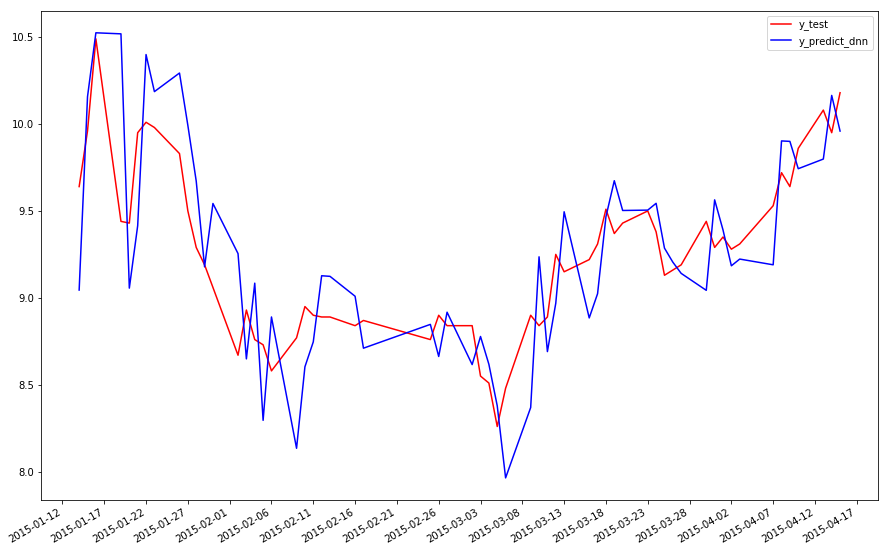

In [27]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


#dates=np.array(d_test['date'])
#print(dates)
xs=[datetime.strptime(d,'%Y-%m-%d') for d in dates]
ys1=test_y[0:60].reshape(-1,n_classes)
ys2=y_predict_lstm
ys3=y_predict_dnn
#print(y_test)
#print(xs)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(xs, ys1,label='y_test',color='r')
#plt.plot(xs,ys2,label="y_predict_lstm",color="y")
plt.plot(xs,ys3,label="y_predict_dnn",color="b")  #purple

plt.gcf().autofmt_xdate()    #xdate可以斜着放，不用横着放
plt.legend(loc="upper right")
plt.show()

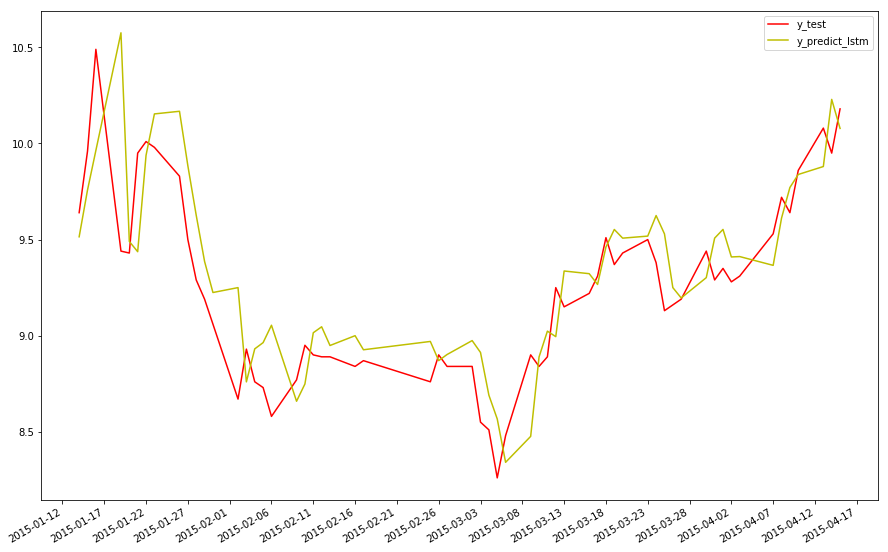

In [26]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


#dates=np.array(d_test['date'])
#print(dates)
xs=[datetime.strptime(d,'%Y-%m-%d') for d in dates]
ys1=test_y[0:60].reshape(-1,n_classes)
ys2=y_predict_lstm
ys3=y_predict_dnn
#print(y_test)
#print(xs)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(xs, ys1,label='y_test',color='r')
plt.plot(xs,ys2,label="y_predict_lstm",color="y")
#plt.plot(xs,ys3,label="y_predict_dnn",color="b")  #purple

plt.gcf().autofmt_xdate()    #xdate可以斜着放，不用横着放
plt.legend(loc="upper right")
plt.show()

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

import sklearn
print("start")

f=open(r'C:\Users\Lenovo\Desktop\学习日记\四个银行数据集后复权\交通银行601328.csv')
d=pd.read_csv(f)

d= d.sort_index(ascending=False)  #按照index降序排列
#print(d)
#print("///////////////////////////////")
d=d.reset_index(drop=True)
#print(d)
d_row=d.shape[0]  #2419行
#print(d[0:1])
#print("***************")
#print(d.iloc[0])
#t=d.iloc[0]
#t=t[['open','close']]
#k=np.array(t)
#print("k:",k)
x0=d.iloc[0:4,1:5]
print(x0)

d=d.iloc[:,:].values


start
    open  close   high    low
0  15.66  15.49  15.80  15.38
1  15.30  15.20  15.40  14.93
2  15.20  15.29  15.50  15.11
3  15.27  15.33  15.55  14.99
